In [4]:
%load_ext autoreload
%autoreload 2 
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
     [0.55, 0.87, 0.66], # journey  (x^2)
     [0.57, 0.85, 0.64], # starts   (x^3) 
     [0.22, 0.58, 0.33], # with     (x^4)
     [0.77, 0.25, 0.10], # one      (x^5)
     [0.05, 0.80, 0.55]] # step     (x*6)
)

In [6]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
inputs.shape

torch.Size([6, 3])

In [7]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0]) # create empty tensor with `vocab_size` sized 
for i, embed in enumerate(inputs):
    attn_scores_2[i] = query.dot(embed) # or torch.dot(embed,  query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


# Normalizing the attention weights

In [8]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In [9]:
# Using softmax
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)
attn_weights_2_naive = softmax_naive(attn_scores_2)
print("attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [10]:
# Now using torch.softmax()
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [11]:
# Creating context vector for inputs[1]
query = inputs[1]
print(inputs)
context_vec_2 = torch.zeros(query.shape)
for i, val in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * val
print(context_vec_2)

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])
tensor([0.4419, 0.6515, 0.5683])


In [12]:
attn_scores = torch.empty(6,6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

# simplified version of above loop
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [13]:
# we normalize each row so each row sum up to 1
attn_weights = torch.softmax(attn_scores, dim=-1)

In [14]:
attn_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [15]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


# 3.4.1 Computing attention weights

In [16]:
x_2 = inputs[1]
d_in = inputs.shape[1] # the input embedding size
d_out = 2 # the output embedding size

In [17]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [20]:
print(x_2)
print(W_query)

tensor([0.5500, 0.8700, 0.6600])
Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])


In [21]:
# compute the query, key, and value vectors for x_2
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


In [73]:
# compute the query, key, and value
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape", keys.shape)
print("value.shape", values.shape)

keys.shape torch.Size([6, 2])
value.shape torch.Size([6, 2])


In [74]:
# to get the attention scores for inputs[1], we dot product the query_2 and keys_2
keys_2 = keys[1]
attn_scores_22 = query_2.dot(keys_2)
print(attn_scores_22)

tensor(1.8524)


In [75]:
# so, to get all the attention scores for each tokens according to inputs[1], we multiply the query[1] and keys 
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


## Compute the attention weights from attention scores

formerly, we computed the attention weights by softmaxing the attention scores.

In [76]:
d_k = keys.shape[-1]
## scaled dot product attention
attn_weights_2 = torch.softmax(attn_scores_2 / d_k ** 0.5, dim=-1)
print(d_k)
print(attn_weights_2)

2
tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


## Compute the context vector
After we get the attention weights for each token to the second token, we multiply it with every attention weight

In [77]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


## And that was to get z(2)
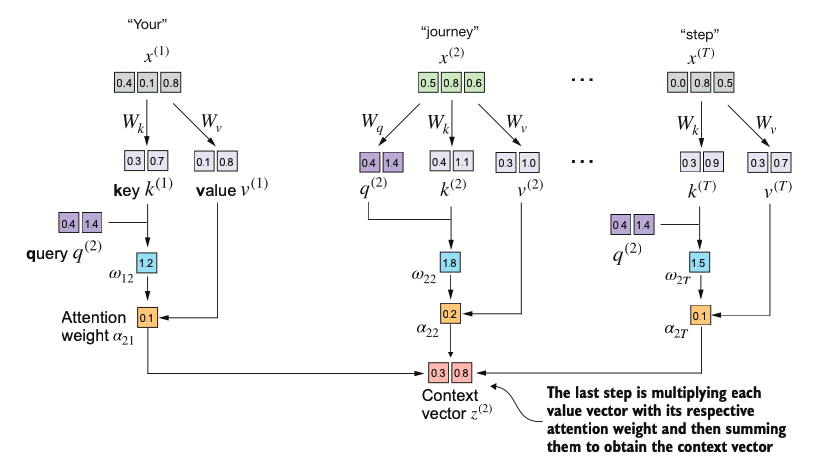